### 1. Setting paths for datasets

In [1]:
import os 
import numpy as np

cwd =  os.getcwd()

train_path = os.path.join(cwd, 'dataset/combined_5celebs_family/train')
validation_path = os.path.join(cwd, 'dataset/combined_5celebs_family/val/')

### 2. Loading the training data

In [2]:
from face_recog.io import ImageDataset

data_train = ImageDataset(train_path)
X_train, y_train = data_train.load_data(convert_xy=True)

In [3]:
print('Number of images:', len(X_train))
print('Number of labels:', len(y_train))

for i, x in enumerate(X_train):
    print('Label:', y_train[i], 'Shape:', x.shape)
    break

Number of images: 192
Number of labels: 192
Label: aditya Shape: (1471, 1140, 3)


### 3. Detecting and Cropping faces 

In [4]:
from face_recog.detector import FaceDetectorTransformer

detector = FaceDetectorTransformer(final_size=(160, 160))
X_train = detector.fit_transform(X_train)
y_train = detector.apply_label_mask(y_train)

print('Shape of detected face datasets:', X_train.shape)
print('Length of label list', len(y_train))

Using TensorFlow backend.


Error finding bounding box: tile cannot extend outside image
Error finding bounding box: Error when checking input: expected input_1 to have shape (None, None, 3) but got array with shape (180, 135, 4)
Error finding bounding box: tile cannot extend outside image
Error finding bounding box: tile cannot extend outside image
Shape of detected face datasets: (188, 160, 160, 3)
Length of label list 188


#### Displaying cropped images

C:\Users\shrey\Anaconda3\envs\face_recog\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


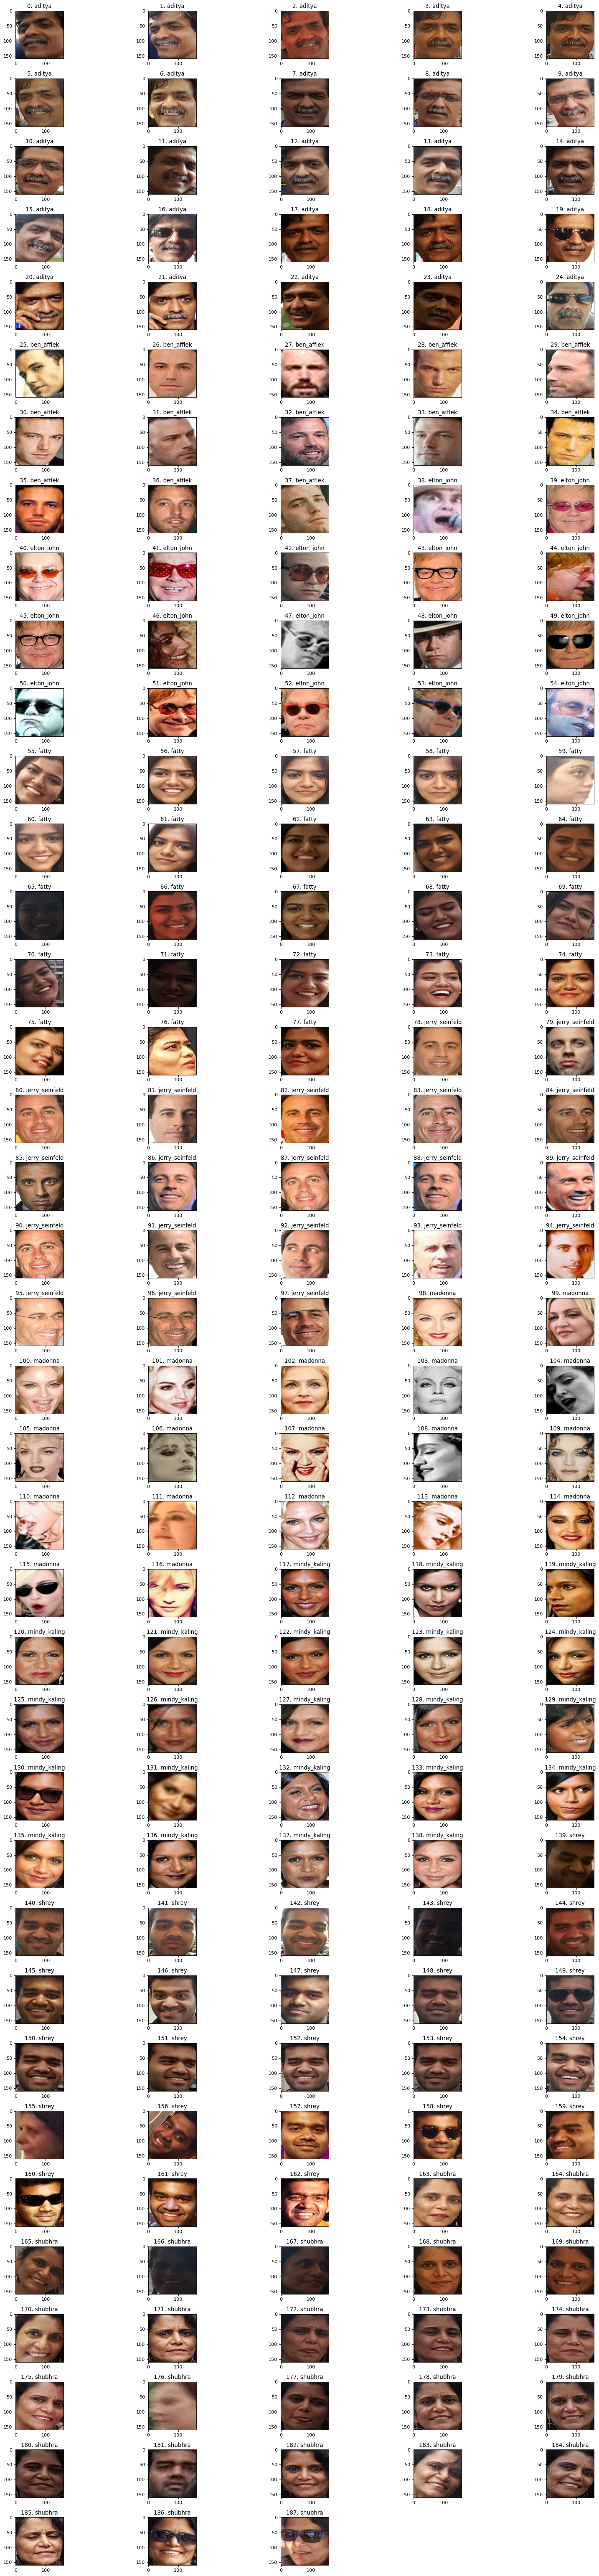

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, (len(X_train)/5 + 1)*2), dpi=80)

columns = 5
for i, v in enumerate(X_train):
    
    ax = plt.subplot(int(len(X_train)/columns)+1, columns, i+1)
    ax.set_title(str(i) + '. '+y_train[i])
    ax.imshow(v)

fig.tight_layout()
fig.show()

#### Remove Images which have been wrongly detected


In [6]:
indices_to_remove = [181, 176, 155, 110, 59, 46]

X, y = [], []
for i in range(len(X_train)):
    if i not in indices_to_remove:
        X.append(X_train[i])
        y.append(y_train[i])
        
X_train = np.array(X)
y_train = y

print('Shape of detected face datasets:', X_train.shape)
print('Length of label list', len(y_train))

Shape of detected face datasets: (182, 160, 160, 3)
Length of label list 182


### 4. Creating embeddings of the face

In [7]:
from face_recog.recognizer import FacenetEmbeddingsTransformer

recognizer = FacenetEmbeddingsTransformer(model_path='models/keras/facenet_keras.h5')
X_train = recognizer.fit_transform(X_train)
print(X_train.shape)

(182, 128)


### 5. Creating a classifier

##### Normalizing embeddings

In [8]:
from sklearn.preprocessing import Normalizer
norm = Normalizer(norm='l2')
X_train = norm.fit_transform(X_train)

##### Training a classifier

#### Classifier #1: Gradient Boosting Classifier

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### Classifier #2: XGBoost

In [30]:
from xgboost import XGBClassifier

clf2 = XGBClassifier()
clf2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

### 6. Validation

#### Loading data

In [18]:
data_val = ImageDataset(validation_path)
X_val, y_val = data_val.load_data(convert_xy=True)

print('Number of images:', len(X_val))
print('Number of labels:', len(y_val))

for i, x in enumerate(X_val):
    print('Label:', y_val[i], 'Shape:', x.shape)
    break

Number of images: 49
Number of labels: 49
Label: aditya Shape: (837, 1224, 3)


#### Detecting faces and generating embeddings

In [19]:
len(y_val)

49

In [20]:
X_val_ = detector.transform(X_val)
y_val = detector.apply_label_mask(y_val)

print('Shape of detected face datasets:', X_val_.shape)
print('Length of label list', len(y_val))

Error finding bounding box: not enough values to unpack (expected 3, got 2)
Shape of detected face datasets: (48, 160, 160, 3)
Length of label list 48


In [21]:
len(detector.label_mask)

49

In [22]:
X_val = recognizer.transform(X_val_)
print(X_val.shape)

(48, 128)


#### Predicting

In [23]:
X_val = norm.transform(X_val)
y_pred = clf.predict(X_val)

#####  Accuracy

In [24]:
from sklearn.metrics import accuracy_score
print('Accuracy:', accuracy_score(y_val, y_pred)*100, '%')

Accuracy: 89.58333333333334 %


### 7. Plotting Results

C:\Users\shrey\Anaconda3\envs\face_recog\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


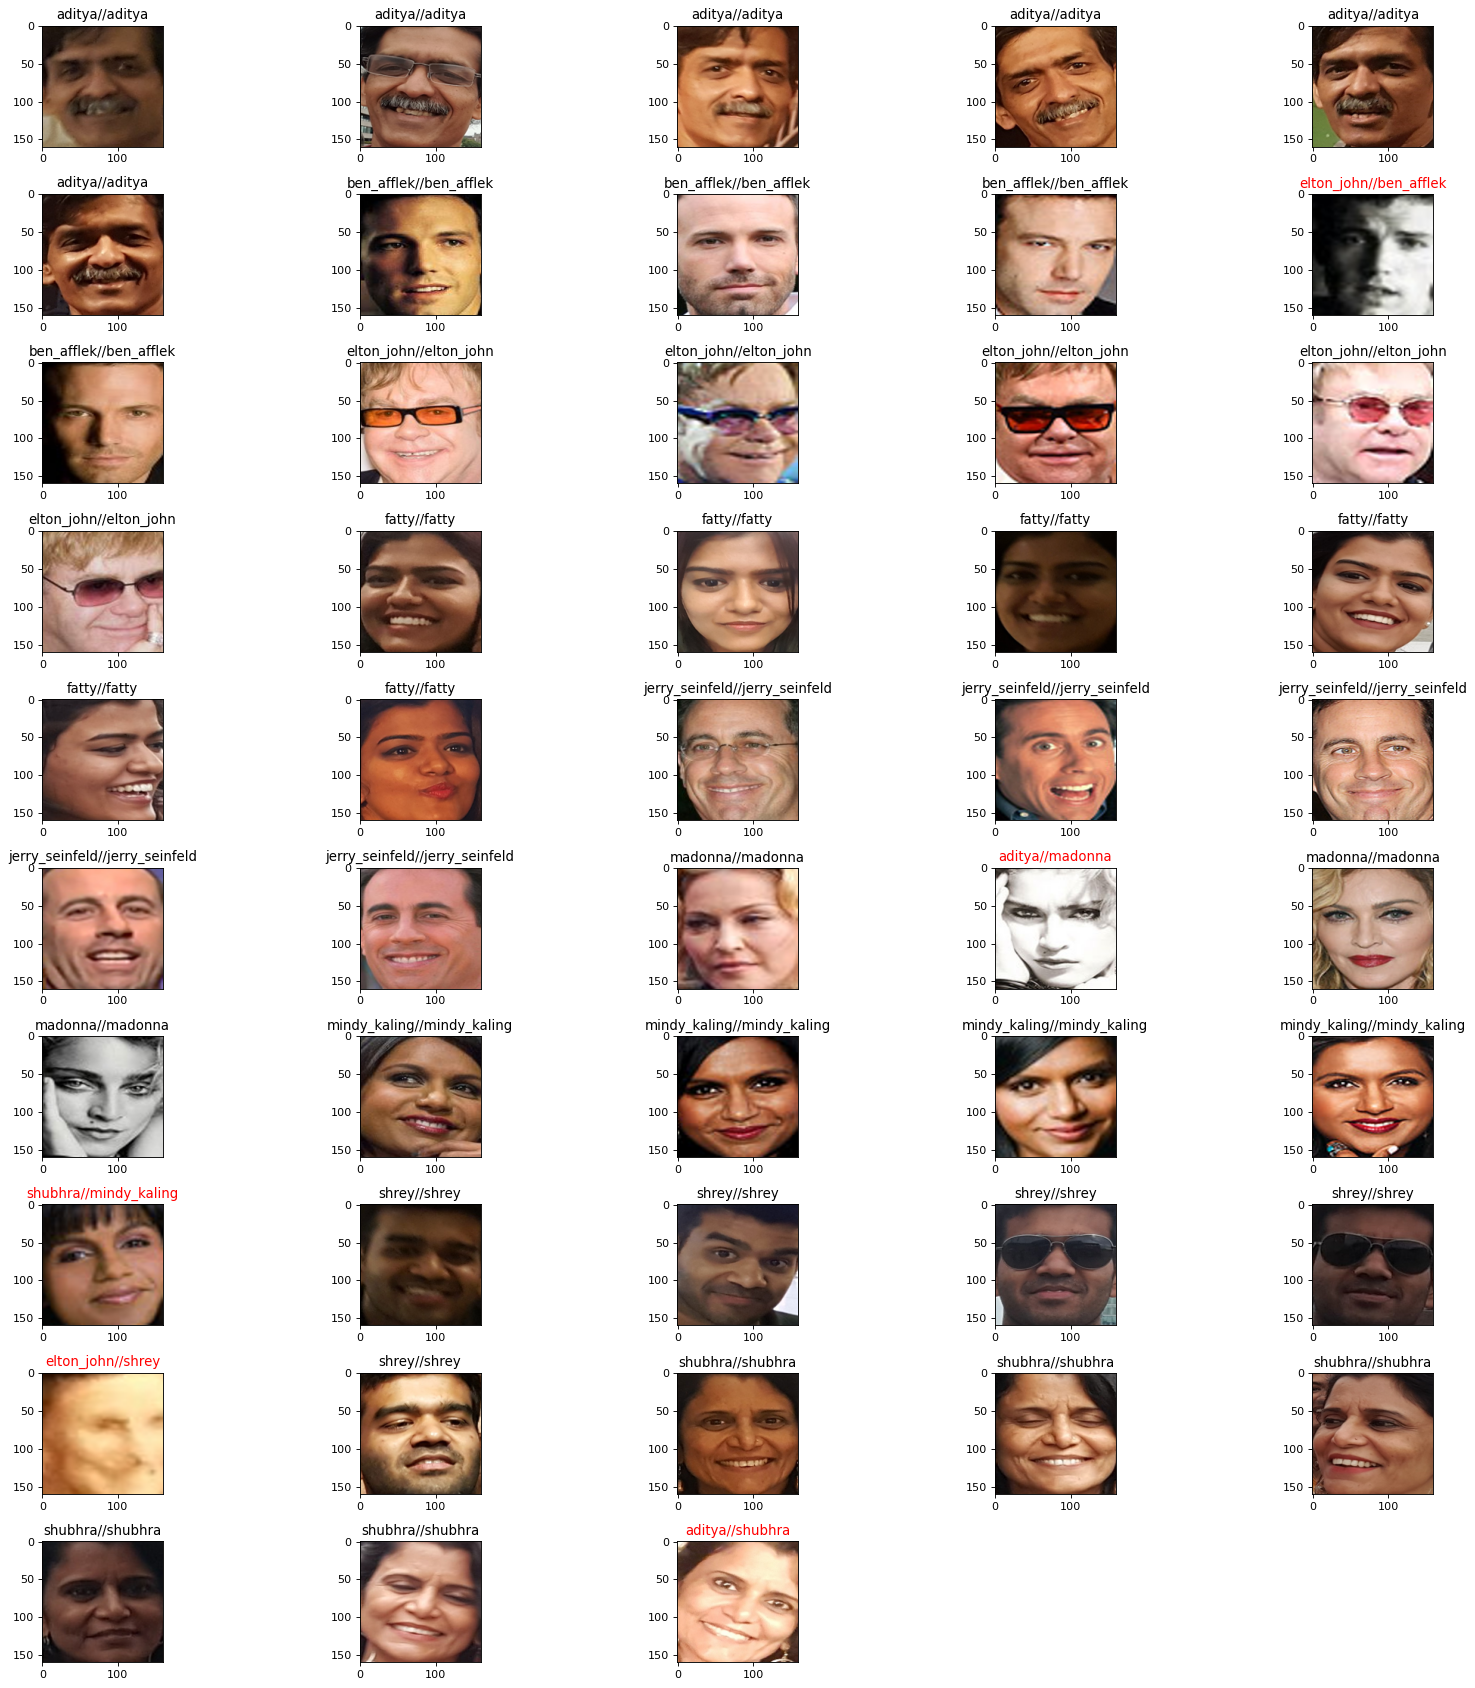

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, (len(X_val_)/5 + 1)*2), dpi=80)

columns = 5
for i, v in enumerate(X_val_):
    
    ax = plt.subplot(int(len(X_val_)/columns)+1, columns, i+1)
    title = str(y_pred[i]+'//'+ y_val[i])
    if y_pred[i] == y_val[i]:
        ax.set_title(title)
    else:
        ax.set_title(title , color='red')
    ax.imshow(v)

fig.tight_layout()
fig.show()

### 8. Testing Results with XGBoost Classifier

#### Predicting

In [27]:
y_pred = clf2.predict(X_val)

#####  Accuracy

In [28]:
from sklearn.metrics import accuracy_score
print('Accuracy:', accuracy_score(y_val, y_pred)*100, '%')

Accuracy: 95.83333333333334 %


### 7. Plotting Results

C:\Users\shrey\Anaconda3\envs\face_recog\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


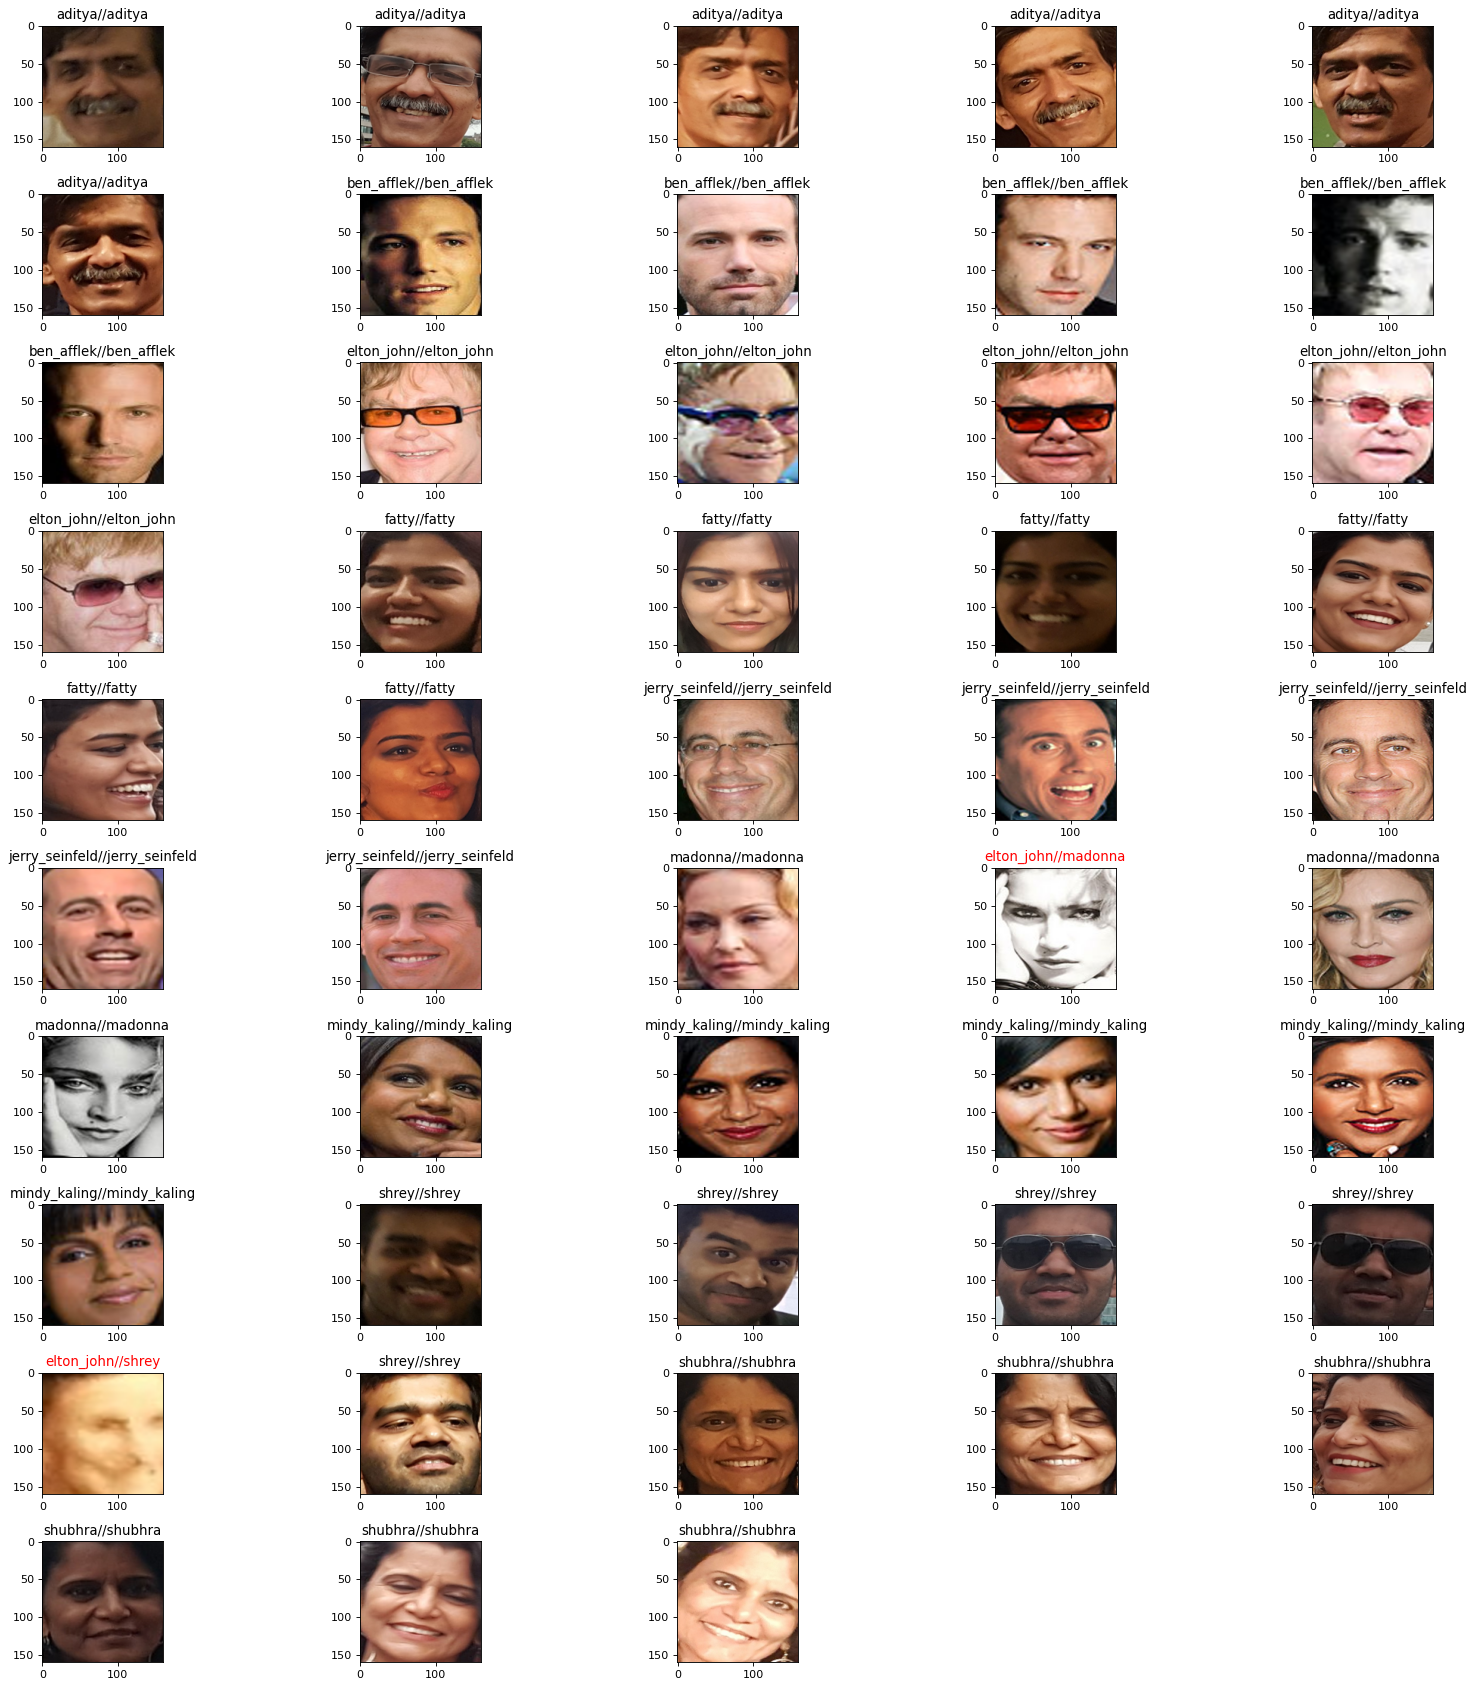

In [29]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, (len(X_val_)/5 + 1)*2), dpi=80)

columns = 5
for i, v in enumerate(X_val_):
    
    ax = plt.subplot(int(len(X_val_)/columns)+1, columns, i+1)
    title = str(y_pred[i]+'//'+ y_val[i])
    if y_pred[i] == y_val[i]:
        ax.set_title(title)
    else:
        ax.set_title(title , color='red')
    ax.imshow(v)

fig.tight_layout()
fig.show()